<a href="https://colab.research.google.com/github/sudeep-009/PricePredictofMarketingCampaign-LinearRegression/blob/dev/Linear_Regression_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <u> Objective </u>
* ### To predict the profit made by a startup on the basis of expenses incurred and the state where they operate

### <u> Tasks </u>
* ### Validate all the assumptions
* ### Compute all the regression evaluation metrics
* ### Comment on the best evaluation metrics for this problem

In [30]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
# Importing the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Assignment/LinearRegressionImplementation/50_Startups.csv')

##**First Lets Understand the dataset provided with us**

In [62]:
print('Number of observation present in this dataset is {}'.format(len(dataset)))

Number of observation present in this dataset is 50


In [63]:
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


**Findings**

1. So there is no null  value present in the dataset.

2. All the features are of float type except State so we need to do transformation on this column.

###**Exploratory Data Analysis**

Numerical Variables

In [65]:
numerical_features = dataset.describe().columns
numerical_features

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit'], dtype='object')

Lets understand the distribution of numerical variables

For this we will use boxplot and violenplot

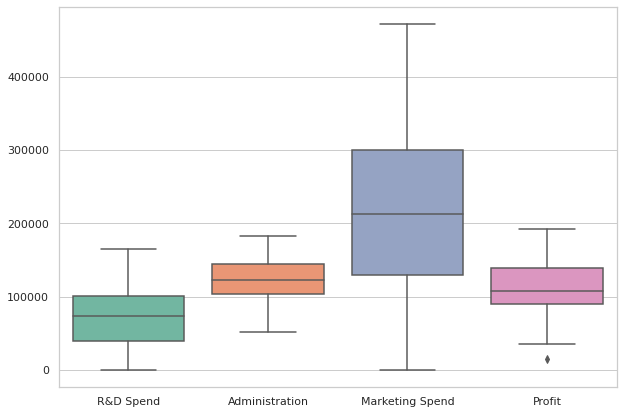

In [66]:
sns.set_theme(rc={'figure.figsize': (10,7)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=dataset[numerical_features], palette="Set2")

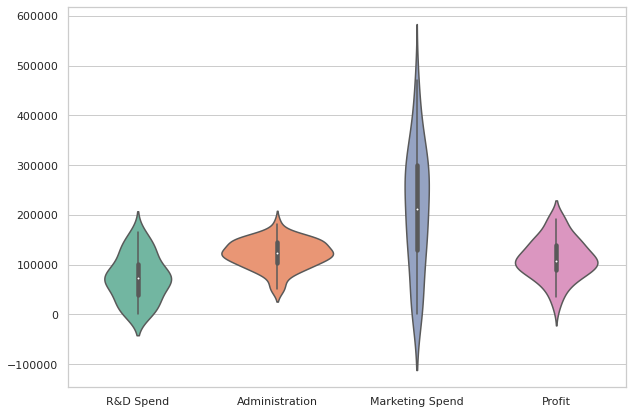

In [67]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=dataset[numerical_features], palette="Set2")

Now we will use scatter plot to understand the relationship between the dependent and independent variables.

In [68]:
input_features = list(set(numerical_features)-{'Profit'})
input_features

['Administration', 'Marketing Spend', 'R&D Spend']

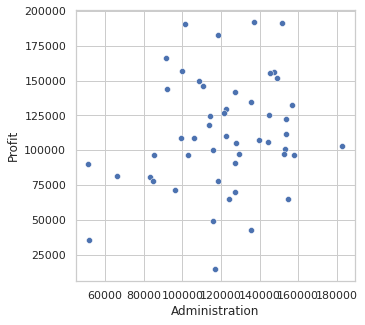

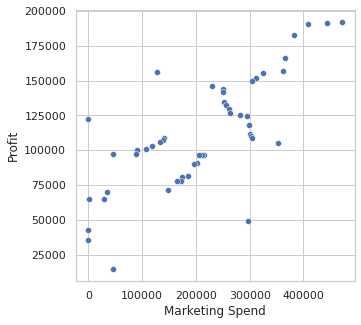

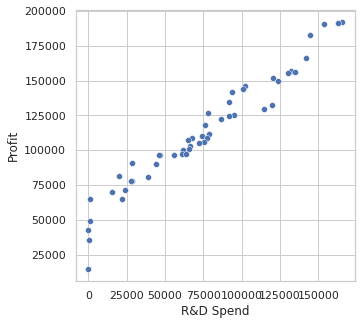

In [69]:
for feature in input_features:
  sns.set_theme(rc={'figure.figsize': (5,5)},style='whitegrid')
  ax = sns.scatterplot(data=dataset, x=feature, y="Profit")
  plt.show()


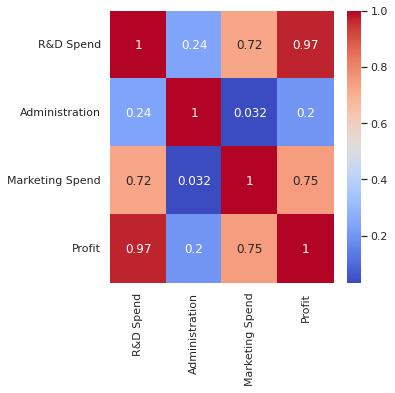

In [70]:
corr_matrix = dataset[numerical_features].corr()
sns.heatmap(abs(corr_matrix),annot=True,cmap='coolwarm')

Drop column Administration as it do not have linear relationship with the target varible Price

In [71]:
dataset.drop('Administration',axis=1,inplace=True)

Checking for Multicollinearity

In [72]:
def calcVif(X):
  vif = pd.DataFrame()
  vif['Variables'] = X.columns
  vif['Vif'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
  return vif

In [76]:
calcVif(dataset[list(set(dataset.describe().columns)-{'Profit'})])

,Variables,Vif
0,Marketing Spend,7.156216
1,R&D Spend,7.156216


###Categorial Variables



In [77]:
dataset['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

In [78]:
a = np.percentile(dataset['Marketing Spend'],q=25)
a

129300.1325

Text(0, 0.5, 'Profit')

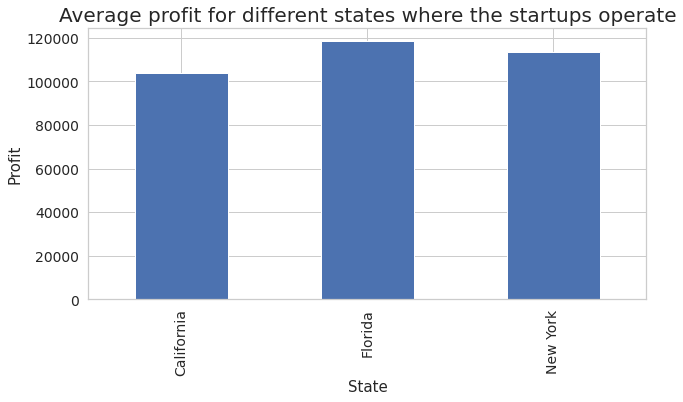

In [79]:
# Create the figure object 
ax = dataset.groupby(['State'])['Profit'].mean().plot.bar(
    figsize = (10,5),
    fontsize = 14
)

# Set the title
ax.set_title("Average profit for different states where the startups operate", fontsize = 20)

# Set x and y-labels
ax.set_xlabel("State", fontsize = 15)
ax.set_ylabel("Profit", fontsize = 15)

In [80]:
dataset.State.value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

In [81]:
# Create dummy variables for the catgeorical variable State
dataset['NewYork_State'] = np.where(dataset['State']=='New York', 1, 0)
dataset['California_State'] = np.where(dataset['State']=='California', 1, 0)
dataset['Florida_State'] = np.where(dataset['State']=='Florida', 1, 0)

# Drop the original column State from the dataframe
dataset.drop(columns=['State'],axis=1,inplace=True)

In [82]:
dataset.head()

,R&D Spend,Marketing Spend,Profit,NewYork_State,California_State,Florida_State
0,165349.20,471784.10,192261.83,1,0,0
1,162597.70,443898.53,191792.06,0,1,0
2,153441.51,407934.54,191050.39,0,0,1
3,144372.41,383199.62,182901.99,1,0,0
4,142107.34,366168.42,166187.94,0,0,1


In [83]:
dependent_variable = 'Profit'

In [84]:
# Create a list of independent variables
independent_variables = list(set(dataset.columns.tolist()) - {dependent_variable})

In [85]:
independent_variables

['Marketing Spend',
 'California_State',
 'NewYork_State',
 'Florida_State',
 'R&D Spend']

In [86]:
# Create the data of independent variables
X = dataset[independent_variables].values

# Create the dependent variable data
y = dataset[dependent_variable].values

In [87]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [88]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [89]:
X_train[0:10]

array([[0.45494286, 0.        , 0.        , 1.        , 0.33561668],
       [0.43561799, 0.        , 1.        , 0.        , 0.2782839 ],
       [0.28413435, 0.        , 0.        , 1.        , 0.45557444],
       [0.44680961, 1.        , 0.        , 0.        , 0.2807759 ],
       [0.62511553, 0.        , 0.        , 1.        , 0.55488118],
       [0.68649342, 0.        , 0.        , 1.        , 0.7880179 ],
       [0.54370828, 0.        , 0.        , 1.        , 0.72539353],
       [0.0040356 , 0.        , 1.        , 0.        , 0.0060492 ],
       [0.        , 0.        , 1.        , 0.        , 0.00327821],
       [0.22709197, 0.        , 1.        , 0.        , 0.39676926]])

In [90]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [91]:
print('------------MODEL PERFORMANCE ON TRAINING DATASET-----------------')
print('mean square error :  {}'.format(mean_squared_error(y_train,regressor.predict(X_train))))
print('root mean square error :  {}'.format(math.sqrt(mean_squared_error(y_train,regressor.predict(X_train)))))
print('r2_score :  {}'.format(r2_score(y_train,regressor.predict(X_train))))

------------MODEL PERFORMANCE ON TRAINING DATASET-----------------
mean square error :  82158239.56230997
root mean square error :  9064.118245163727
r2_score :  0.9498261378977877


In [92]:
print('------------MODEL PERFORMANCE ON TEST DATASET-----------------')
print('mean square error :  {}'.format(mean_squared_error(y_test,regressor.predict(X_test))))
print('root mean square error :  {}'.format(math.sqrt(mean_squared_error(y_test,regressor.predict(X_test)))))
print('r2_score :  {}'.format(r2_score(y_test,regressor.predict(X_test))))

------------MODEL PERFORMANCE ON TEST DATASET-----------------
mean square error :  70726699.14472966
root mean square error :  8409.916714494244
r2_score :  0.9446968769427517
